In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Initial Task**
#### Predicting whether a given value of Δη belongs to the signal or the background

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams.update({'font.size': 30})


import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc

#import optuna

## **Visualizing the Dataset**

In [ ]:
signal = pd.read_csv('/content/drive/MyDrive/PYD411/deltaeta_spin0_noncoll.txt').reset_index(drop=True)
signal.columns = ['Value']
bg = pd.read_csv('/content/drive/MyDrive/PYD411/deltaeta_spin2ff_coll.txt').reset_index(drop=True)
bg.columns = ['Value']

In [ ]:
signal.describe()

,Value
count,122854.000000
mean,-0.003049
std,1.442249
min,-4.850000
25%,-0.978000
50%,-0.001200
75%,0.970000
max,4.820000


In [ ]:
bg.describe()

,Value
count,133619.000000
mean,0.003904
std,1.669666
min,-4.760000
25%,-1.450000
50%,0.080100
75%,1.450000
max,4.690000


In [ ]:
num_bins = 50
width = (signal.max() -signal.min())/num_bins 

In [ ]:
signal_freq, intervals = np.histogram(signal, bins = num_bins, density = True)
signal_freq

array([0.0003367 , 0.00063131, 0.00290404, 0.00378788, 0.0061027 ,
       0.01047981, 0.01338386, 0.02015996, 0.02550509, 0.03333338,
       0.04196134, 0.05576608, 0.06645633, 0.08472235, 0.1045877 ,
       0.12087561, 0.13627967, 0.16936053, 0.18341779, 0.20888079,
       0.22748351, 0.24191956, 0.25883878, 0.2696553 , 0.27845161,
       0.27537921, 0.27276978, 0.26308963, 0.24827479, 0.23316534,
       0.20795486, 0.18808951, 0.17226457, 0.14242446, 0.12272746,
       0.10677626, 0.08282841, 0.06788731, 0.05799672, 0.04351859,
       0.03489063, 0.02521048, 0.01986535, 0.01409935, 0.0105219 ,
       0.00694446, 0.00433502, 0.00294613, 0.00092593, 0.00046296])

In [ ]:
bg_freq, intervals_2 = np.histogram(bg, bins = num_bins, density = True)
bg_freq

array([2.77183911e-04, 5.93965524e-04, 1.10873564e-03, 2.41545980e-03,
       3.99936786e-03, 7.40477020e-03, 1.02558047e-02, 1.60370692e-02,
       2.54217244e-02, 3.40144257e-02, 5.42884489e-02, 8.16900584e-02,
       1.09289656e-01, 1.45838335e-01, 1.85356841e-01, 2.28320347e-01,
       2.66769716e-01, 2.90805521e-01, 2.93181383e-01, 2.75758394e-01,
       2.41268796e-01, 1.81951439e-01, 1.14437358e-01, 5.70998857e-02,
       1.43343680e-02, 8.63229895e-03, 3.52023567e-02, 9.19458631e-02,
       1.54985404e-01, 2.19608853e-01, 2.61938796e-01, 2.92785406e-01,
       2.97101555e-01, 2.73659716e-01, 2.47525233e-01, 2.03452991e-01,
       1.59539140e-01, 1.26079082e-01, 9.07975298e-02, 5.97133340e-02,
       4.48641959e-02, 3.13613797e-02, 2.03928163e-02, 1.17605174e-02,
       7.24637939e-03, 5.06850581e-03, 2.61344831e-03, 1.70270117e-03,
       7.12758629e-04, 3.95977016e-04])

In [ ]:
signal_df = pd.DataFrame(index = np.linspace(1,num_bins,num_bins), columns = ['start', 'end', 'mid','freq','label'])
signal_df['start'] = intervals[:-1]
signal_df['end'] = intervals[1:]
signal_df['mid'] = (signal_df['start'] + signal_df['end'])/2
signal_df['freq'] = signal_freq
signal_df['label'] = 1

In [ ]:
bg_df = pd.DataFrame(index = np.linspace(1,num_bins,num_bins), columns = ['start', 'end', 'mid','freq'])
bg_df['start'] = intervals_2[:-1]
bg_df['end'] = intervals_2[1:]
bg_df['mid'] = (bg_df['start'] + bg_df['end'])/2
bg_df['freq'] = bg_freq
bg_df['label'] = 0

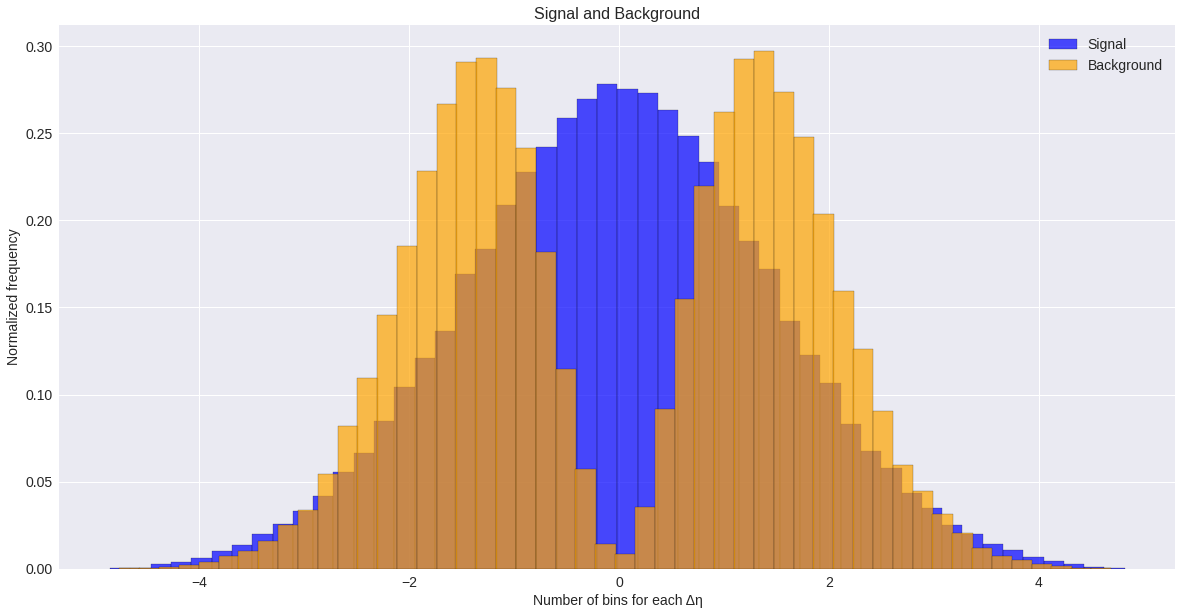

In [ ]:
plt.bar(signal_df['mid'], signal_df['freq'], width = width, color='blue', ec= 'black',alpha = 0.7)
plt.bar(bg_df['mid'], bg_df['freq'], width = width, color='orange', ec= 'black',alpha = 0.7)
plt.xlabel("Number of bins for each Δη",fontsize = 14)
plt.ylabel("Normalized frequency",fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Signal and Background',fontsize=16)
plt.legend(['Signal','Background'],fontsize = 14)
plt.show()

In [ ]:
intervals

### Preparing Data for input to Model

In [ ]:
data = pd.DataFrame(columns = ['Value', 'Probability','Label'])
data

,Value,Probability,Label


In [ ]:
signal_dict = {}
for index, row in signal_df.iterrows():
  signal_dict[row['start']] = row['freq']

bg_dict = {}
for index, row in bg_df.iterrows():
  bg_dict[row['start']] = row['freq']

In [ ]:
data = {}
for index, row in tqdm(signal.iterrows()):
  val = row['Value']
  eps = 1e-7
  idx = np.searchsorted(intervals,val-eps,side = 'right')
  left = intervals[idx-1]
  if(left==intervals[-1]):
    left = intervals[-2]
  d = {'Value': val,'Probability':signal_dict[left],'Label':1}
  data[index] = d

122854it [00:13, 8873.02it/s]


In [ ]:
data2 = {}
for index, row in tqdm(bg.iterrows()):
  val = row['Value']
  eps = 1e-7
  idx = np.searchsorted(intervals_2,val-eps,side = 'right')
  left = intervals_2[idx-1]
  if(left==intervals_2[-1]):
    left = intervals_2[-2]
  d = {'Value': val,'Probability':bg_dict[left],'Label':0}
  data2[index] = d

133619it [00:10, 13035.26it/s]


In [ ]:
data = pd.concat([pd.DataFrame(data).T,pd.DataFrame(data2).T],ignore_index=True)

In [ ]:
data = data.sample(frac = 1).reset_index(drop=True)
data

,Value,Probability,Label
0,-0.891,0.241269,0.0
1,-0.193,0.278452,1.0
2,1.560,0.273660,0.0
3,0.845,0.233165,1.0
4,1.860,0.122727,1.0
...,...,...,...
256468,1.450,0.297102,0.0
256469,-1.080,0.275758,0.0
256470,-2.530,0.055766,1.0
256471,1.300,0.297102,0.0


In [ ]:
data = torch.tensor(data.to_numpy(), dtype = torch.float32)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data[:,:-1], 
                                                    data[:,-1], 
                                                    random_state = 1,
                                                    stratify = data[:,-1]
                                                   )

## **Neural Network with 1 hidden layer**

In [ ]:
n_input, n_hidden, n_out, learning_rate, num_epochs = 2, 112, 1, 0.03598887220487900, 500

In [ ]:
def build_model(params):
    model = nn.Sequential(nn.Linear(n_input, params['n_hidden']),
                          nn.ReLU(),
                          nn.Linear(params['n_hidden'], n_out),
                          nn.Sigmoid())
    if(params['optimizer']=='Adam'):
      optimizer = torch.optim.Adam(model.parameters(), lr = params['learning_rate'])
    if(params['optimizer']=='RMSprop'):
      optimizer = torch.optim.RMSprop(model.parameters(), lr = params['learning_rate'])
    if(params['optimizer']=='SGD'):
      optimizer = torch.optim.SGD(model.parameters(), lr = params['learning_rate'])
    print(model)
    return model,optimizer

params = {'n_hidden':n_hidden,'optimizer':"Adam",'learning_rate':learning_rate}
model,optimizer = build_model(params)

Sequential(
  (0): Linear(in_features=2, out_features=112, bias=True)
  (1): ReLU()
  (2): Linear(in_features=112, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:25<00:00,  5.84it/s]


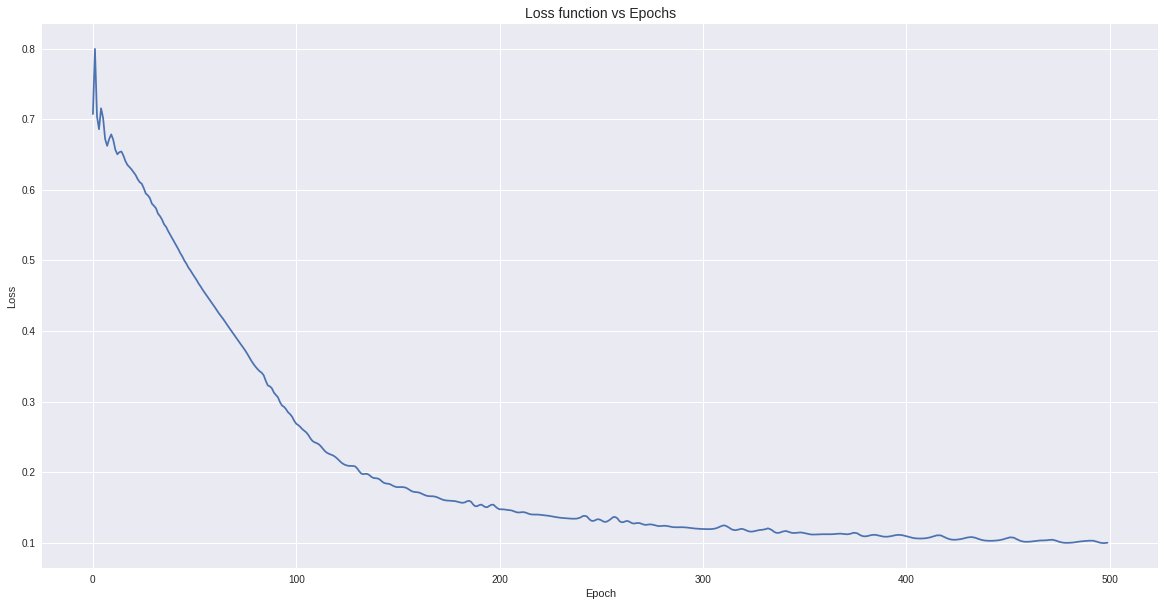

In [ ]:
def train(params, model, optimizer, show_plot = True):

  losses = []
  loss_fxn = nn.BCELoss()
  model.train()

  for epoch in tqdm(range(num_epochs)):
      optimizer.zero_grad()
      pred_y = model(x_train)
      loss = loss_fxn(torch.squeeze(pred_y), y_train)
      losses.append(loss.item())
      loss.backward()
      optimizer.step()
      
  if(show_plot):
    plt.plot(losses)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Loss function vs Epochs',fontsize=14)
    plt.savefig('best_model_loss.png')
    plt.show()
  return losses

# losses = train(params,model,optimizer)

In [ ]:
def evaluate(model):
  model.eval()
  y_save = []
  with torch.no_grad():
      y_pred = model(x_test).numpy()
      y_save = y_pred.copy()
      y_pred[y_pred <= 0.5] = 0
      y_pred[y_pred > 0.5] = 1
  return y_pred, y_save

# y_pred, y_save = evaluate(model)

In [ ]:
def train_and_evaluate(params, model, optimizer):
  losses = train(params,model,optimizer,False)
  y_pred, y_save = evaluate(model)
  return accuracy_score(y_pred, y_test), y_pred, y_save, losses

In [ ]:
accuracy, y_pred, y_save, losses = train_and_evaluate(params,model,optimizer)
print('')
print('Accuracy: ',accuracy)

100%|██████████| 500/500 [01:29<00:00,  5.59it/s]



Accuracy:  0.9683089255914783


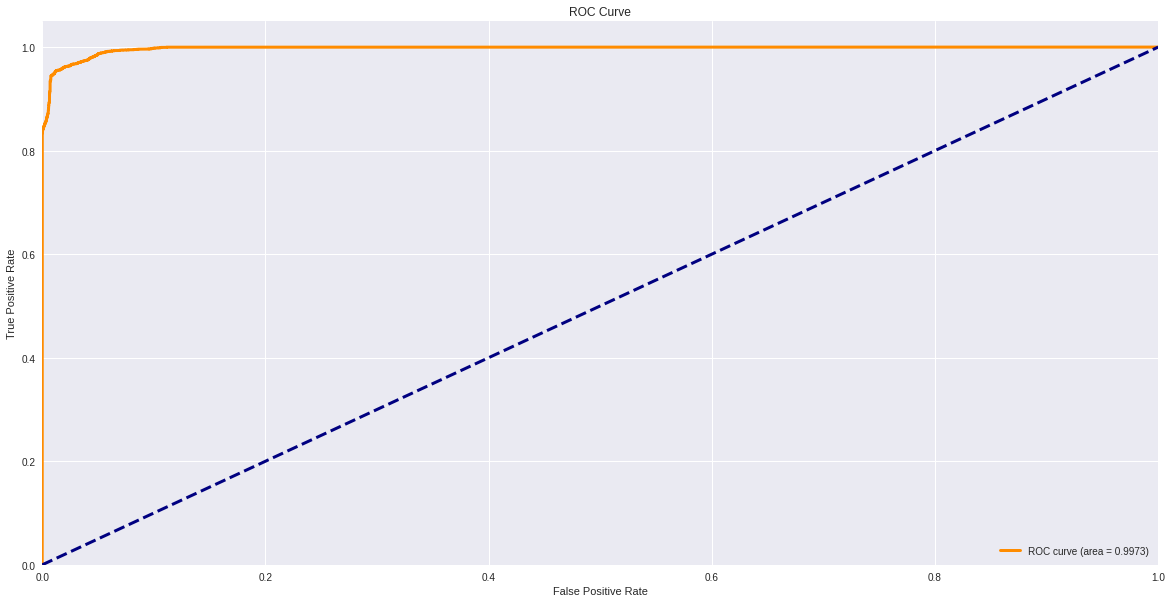

In [ ]:
def plot_roc(y_test,y_save):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  fpr, tpr, _ = roc_curve(y_test.detach().numpy(), np.array(y_save))
  roc_auc = auc(fpr, tpr)
  plt.figure()
  lw = 3
  plt.plot(
      fpr,
      tpr,
      color="darkorange",
      lw=lw,
      label="ROC curve (area = %0.4f)" % roc_auc,
  )
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend(loc="lower right")
  plt.savefig('best_model_roc.png')
  plt.show()

plot_roc(y_test,y_save)

In [ ]:
class Logistic_Reg_model(torch.nn.Module):
  def __init__(self,no_input_features):
    super(Logistic_Reg_model,self).__init__()
    self.layer1 = torch.nn.Linear(no_input_features,20)
    self.layer2 = torch.nn.Linear(20,1)
    
  def forward(self,x):
    y_predicted = self.layer1(x)
    y_predicted = torch.sigmoid(self.layer2(y_predicted))
    return y_predicted

model_lr = Logistic_Reg_model(2)

In [ ]:
optimizer = torch.optim.Adam(model_lr.parameters(), lr = 0.1)

NameError: ignored

100%|██████████| 500/500 [00:13<00:00, 36.91it/s]


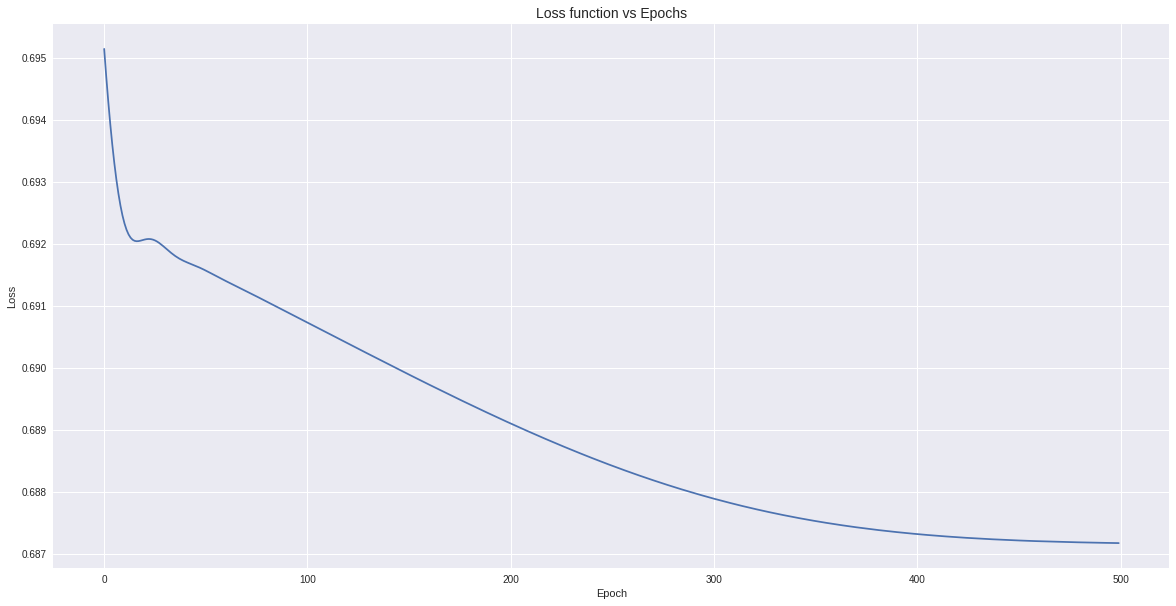

In [ ]:
def train(model, optimizer, show_plot = True):
  
  losses = []
  loss_fxn = nn.BCELoss()
  model.train()

  for epoch in tqdm(range(500)):
    optimizer.zero_grad()
    pred_y = model(x_train)
    loss = loss_fxn(torch.squeeze(pred_y), y_train)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
  if(show_plot):
    plt.plot(losses)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Loss function vs Epochs',fontsize=14)
    plt.savefig('best_model_loss.png')
    plt.show()
    
  return losses

losses = train(model_lr, optimizer)

###Maximizing the accuracy using Optuna

In [ ]:
def objective(trial):
    params = {
              'n_hidden': trial.suggest_int('n_hidden', 4, 128),
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
              'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD']),
              }
    
    model,optimizer = build_model(params)
    accuracy,_,_,_ = train_and_evaluate(params, model,optimizer)

    return accuracy

In [ ]:
# study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
# study.optimize(objective, n_trials=30)

[I 2022-09-23 19:52:24,244] A new study created in memory with name: no-name-1890b1dc-2a50-4ba1-875e-cdfd51cd5ca0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=98, bias=True)
  (1): ReLU()
  (2): Linear(in_features=98, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:13<00:00,  6.83it/s]
[I 2022-09-23 19:53:37,501] Trial 0 finished with value: 0.6378920444797954 and parameters: {'n_hidden': 98, 'learning_rate': 0.2974787338618753, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.6378920444797954.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=76, bias=True)
  (1): ReLU()
  (2): Linear(in_features=76, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:10<00:00,  7.10it/s]
[I 2022-09-23 19:54:47,941] Trial 1 finished with value: 0.658993434083501 and parameters: {'n_hidden': 76, 'learning_rate': 0.12827425933783632, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.658993434083501.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=15, bias=True)
  (1): ReLU()
  (2): Linear(in_features=15, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [00:17<00:00, 28.64it/s]
[I 2022-09-23 19:55:05,434] Trial 2 finished with value: 0.8602754253809324 and parameters: {'n_hidden': 15, 'learning_rate': 0.004446329002890748, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.8602754253809324.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=45, bias=True)
  (1): ReLU()
  (2): Linear(in_features=45, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [00:51<00:00,  9.67it/s]
[I 2022-09-23 19:55:57,176] Trial 3 finished with value: 0.8376144356586971 and parameters: {'n_hidden': 45, 'learning_rate': 0.008956919381978437, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.8602754253809324.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=52, bias=True)
  (1): ReLU()
  (2): Linear(in_features=52, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [00:55<00:00,  9.01it/s]
[I 2022-09-23 19:56:52,739] Trial 4 finished with value: 0.563389946817636 and parameters: {'n_hidden': 52, 'learning_rate': 0.004130082798527253, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.8602754253809324.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=119, bias=True)
  (1): ReLU()
  (2): Linear(in_features=119, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [02:02<00:00,  4.10it/s]
[I 2022-09-23 19:58:54,842] Trial 5 finished with value: 0.8834666791434677 and parameters: {'n_hidden': 119, 'learning_rate': 0.024268874389818083, 'optimizer': 'RMSprop'}. Best is trial 5 with value: 0.8834666791434677.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=54, bias=True)
  (1): ReLU()
  (2): Linear(in_features=54, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [00:56<00:00,  8.93it/s]
[I 2022-09-23 19:59:50,890] Trial 6 finished with value: 0.8381602957001825 and parameters: {'n_hidden': 54, 'learning_rate': 0.007755953330658096, 'optimizer': 'RMSprop'}. Best is trial 5 with value: 0.8834666791434677.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=69, bias=True)
  (1): ReLU()
  (2): Linear(in_features=69, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [00:53<00:00,  9.33it/s]
[I 2022-09-23 20:00:44,549] Trial 7 finished with value: 0.8318907032236934 and parameters: {'n_hidden': 69, 'learning_rate': 0.026818144099998973, 'optimizer': 'RMSprop'}. Best is trial 5 with value: 0.8834666791434677.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=97, bias=True)
  (1): ReLU()
  (2): Linear(in_features=97, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:12<00:00,  6.88it/s]
[I 2022-09-23 20:01:57,291] Trial 8 finished with value: 0.6377984684726836 and parameters: {'n_hidden': 97, 'learning_rate': 0.0024160698288269965, 'optimizer': 'SGD'}. Best is trial 5 with value: 0.8834666791434677.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=44, bias=True)
  (1): ReLU()
  (2): Linear(in_features=44, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [00:37<00:00, 13.21it/s]
[I 2022-09-23 20:02:35,181] Trial 9 finished with value: 0.9564247726882827 and parameters: {'n_hidden': 44, 'learning_rate': 0.05011494874138596, 'optimizer': 'Adam'}. Best is trial 9 with value: 0.9564247726882827.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [00:09<00:00, 55.36it/s]
[I 2022-09-23 20:02:44,272] Trial 10 finished with value: 0.8728613983374662 and parameters: {'n_hidden': 5, 'learning_rate': 0.09534304874862513, 'optimizer': 'Adam'}. Best is trial 9 with value: 0.9564247726882827.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=127, bias=True)
  (1): ReLU()
  (2): Linear(in_features=127, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [02:00<00:00,  4.16it/s]
[I 2022-09-23 20:04:44,588] Trial 11 finished with value: 0.9664841934527987 and parameters: {'n_hidden': 127, 'learning_rate': 0.03070600731157846, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.9664841934527987.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=29, bias=True)
  (1): ReLU()
  (2): Linear(in_features=29, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [00:30<00:00, 16.56it/s]
[I 2022-09-23 20:05:14,842] Trial 12 finished with value: 0.9590137088850419 and parameters: {'n_hidden': 29, 'learning_rate': 0.06169820318734166, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.9664841934527987.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=28, bias=True)
  (1): ReLU()
  (2): Linear(in_features=28, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [00:28<00:00, 17.68it/s]
[I 2022-09-23 20:05:43,168] Trial 13 finished with value: 0.6570283379341537 and parameters: {'n_hidden': 28, 'learning_rate': 0.001006797400324047, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.9664841934527987.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=127, bias=True)
  (1): ReLU()
  (2): Linear(in_features=127, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:51<00:00,  4.48it/s]
[I 2022-09-23 20:07:34,750] Trial 14 finished with value: 0.9611347650462422 and parameters: {'n_hidden': 127, 'learning_rate': 0.27865346408328723, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.9664841934527987.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:41<00:00,  4.91it/s]
[I 2022-09-23 20:09:16,746] Trial 15 finished with value: 0.9611503610474275 and parameters: {'n_hidden': 128, 'learning_rate': 0.3290987715142456, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.9664841934527987.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=110, bias=True)
  (1): ReLU()
  (2): Linear(in_features=110, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:33<00:00,  5.33it/s]
[I 2022-09-23 20:10:50,695] Trial 16 finished with value: 0.9655952213852368 and parameters: {'n_hidden': 110, 'learning_rate': 0.3594409050775394, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.9664841934527987.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=107, bias=True)
  (1): ReLU()
  (2): Linear(in_features=107, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:27<00:00,  5.69it/s]
[I 2022-09-23 20:12:18,561] Trial 17 finished with value: 0.9666401534646517 and parameters: {'n_hidden': 107, 'learning_rate': 0.13782620155439174, 'optimizer': 'Adam'}. Best is trial 17 with value: 0.9666401534646517.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=86, bias=True)
  (1): ReLU()
  (2): Linear(in_features=86, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:10<00:00,  7.14it/s]
[I 2022-09-23 20:13:28,640] Trial 18 finished with value: 0.884963895257256 and parameters: {'n_hidden': 86, 'learning_rate': 0.14003501850013034, 'optimizer': 'Adam'}. Best is trial 17 with value: 0.9666401534646517.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=111, bias=True)
  (1): ReLU()
  (2): Linear(in_features=111, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:34<00:00,  5.30it/s]
[I 2022-09-23 20:15:02,969] Trial 19 finished with value: 0.9628035371730689 and parameters: {'n_hidden': 111, 'learning_rate': 0.014614354553899938, 'optimizer': 'Adam'}. Best is trial 17 with value: 0.9666401534646517.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=96, bias=True)
  (1): ReLU()
  (2): Linear(in_features=96, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:13<00:00,  6.78it/s]
[I 2022-09-23 20:16:16,753] Trial 20 finished with value: 0.9657823733994604 and parameters: {'n_hidden': 96, 'learning_rate': 0.06902679124302685, 'optimizer': 'Adam'}. Best is trial 17 with value: 0.9666401534646517.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=104, bias=True)
  (1): ReLU()
  (2): Linear(in_features=104, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:26<00:00,  5.79it/s]
[I 2022-09-23 20:17:43,156] Trial 21 finished with value: 0.9629127091813658 and parameters: {'n_hidden': 104, 'learning_rate': 0.04336196818312995, 'optimizer': 'Adam'}. Best is trial 17 with value: 0.9666401534646517.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=89, bias=True)
  (1): ReLU()
  (2): Linear(in_features=89, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:25<00:00,  5.84it/s]
[I 2022-09-23 20:19:08,800] Trial 22 finished with value: 0.9638484692524837 and parameters: {'n_hidden': 89, 'learning_rate': 0.1805661584264292, 'optimizer': 'Adam'}. Best is trial 17 with value: 0.9666401534646517.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=118, bias=True)
  (1): ReLU()
  (2): Linear(in_features=118, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:52<00:00,  4.43it/s]
[I 2022-09-23 20:21:01,786] Trial 23 finished with value: 0.9607916530201657 and parameters: {'n_hidden': 118, 'learning_rate': 0.0709261027865521, 'optimizer': 'Adam'}. Best is trial 17 with value: 0.9666401534646517.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=84, bias=True)
  (1): ReLU()
  (2): Linear(in_features=84, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:22<00:00,  6.06it/s]
[I 2022-09-23 20:22:24,352] Trial 24 finished with value: 0.9625851931564747 and parameters: {'n_hidden': 84, 'learning_rate': 0.01639707423541863, 'optimizer': 'Adam'}. Best is trial 17 with value: 0.9666401534646517.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=116, bias=True)
  (1): ReLU()
  (2): Linear(in_features=116, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:37<00:00,  5.11it/s]
[I 2022-09-23 20:24:02,367] Trial 25 finished with value: 0.9666401534646517 and parameters: {'n_hidden': 116, 'learning_rate': 0.037699042076936105, 'optimizer': 'Adam'}. Best is trial 17 with value: 0.9666401534646517.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=117, bias=True)
  (1): ReLU()
  (2): Linear(in_features=117, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:29<00:00,  5.57it/s]
[I 2022-09-23 20:25:32,168] Trial 26 finished with value: 0.9685272696080724 and parameters: {'n_hidden': 117, 'learning_rate': 0.03751239226618552, 'optimizer': 'Adam'}. Best is trial 26 with value: 0.9685272696080724.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=112, bias=True)
  (1): ReLU()
  (2): Linear(in_features=112, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:21<00:00,  6.16it/s]
[I 2022-09-23 20:26:53,459] Trial 27 finished with value: 0.9697437577005256 and parameters: {'n_hidden': 112, 'learning_rate': 0.03598887220487901, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.9697437577005256.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=106, bias=True)
  (1): ReLU()
  (2): Linear(in_features=106, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:23<00:00,  6.02it/s]
[I 2022-09-23 20:28:16,554] Trial 28 finished with value: 0.9676382975405106 and parameters: {'n_hidden': 106, 'learning_rate': 0.1901150721313645, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.9697437577005256.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Sequential(
  (0): Linear(in_features=2, out_features=99, bias=True)
  (1): ReLU()
  (2): Linear(in_features=99, out_features=1, bias=True)
  (3): Sigmoid()
)


100%|██████████| 500/500 [01:15<00:00,  6.62it/s]
[I 2022-09-23 20:29:32,101] Trial 29 finished with value: 0.6483881532774997 and parameters: {'n_hidden': 99, 'learning_rate': 0.1972605559928286, 'optimizer': 'SGD'}. Best is trial 27 with value: 0.9697437577005256.


In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

n_hidden: 112
learning_rate: 0.03598887220487901
optimizer: Adam


In [ ]:
results = study.trials_dataframe()
results.drop(['number','datetime_start','datetime_complete','duration','state'], axis=1, inplace=True)
results.rename(columns = {'value':'accuracy'}, inplace = True)
results

,accuracy,params_learning_rate,params_n_hidden,params_optimizer
0,0.637892,0.297479,98,SGD
1,0.658993,0.128274,76,SGD
2,0.860275,0.004446,15,RMSprop
3,0.837614,0.008957,45,RMSprop
4,0.563390,0.004130,52,SGD
5,0.883467,0.024269,119,RMSprop
6,0.838160,0.007756,54,RMSprop
7,0.831891,0.026818,69,RMSprop
8,0.637798,0.002416,97,SGD
9,0.956425,0.050115,44,Adam


In [ ]:
results.to_csv('optuna_results.csv')

In [ ]:
data = pd.read_csv('/content/Data/esigptl1out.txt', sep = '\t', names = ['pt', 'deltaeta']).reset_index(drop=True)
data.head()

,pt,deltaeta
0,0,43.0
1,1,37.2
2,17,38.1
3,29,49.1
4,30,46.3


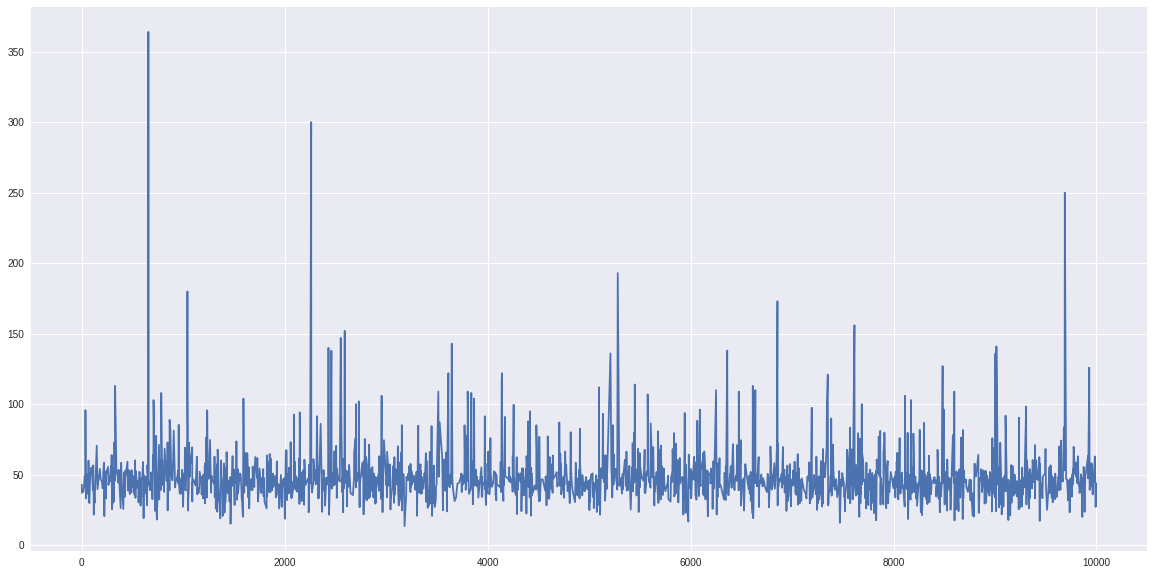

In [ ]:
plt.plot(data['pt'], data['deltaeta'])

In [ ]:
data = pd.read_csv('/content/Data/data_pp_e+e-.csv')
data.head()

,invariant_mass_electron,px1,py1,ptl1,px2,py2,ptl2,etal1,etal2
0,92.3608,23.5840,41.50800,47.7401,-0.265954,-47.48210,47.4828,0.141171,0.278032
1,90.9088,37.6121,11.65630,39.3769,-33.767800,-15.68980,37.2349,1.493910,0.282925
2,79.7348,-47.8682,-40.11020,62.4515,4.626220,22.87610,23.3392,-1.136180,-0.269716
3,96.3826,45.0804,-3.18353,45.1926,-38.092000,3.51633,38.2539,0.986720,2.100410
4,89.4622,20.6118,-48.04220,52.2771,-3.156180,31.25360,31.4126,-1.598680,-0.651694


In [ ]:
data = pd.read_csv('/content/Data/data_pp_mu+mu-.csv')
data.head()

,invariant_mass_moun,px1,py1,ptl1,px2,py2,ptl2,etal1,etal2
0,92.5245,35.64250,27.17210,44.8187,-31.59160,0.267421,31.5928,1.904550,0.462500
1,92.6410,20.51450,-1.92013,20.6042,-12.84380,8.516500,15.4108,-1.137450,2.090440
2,26.8235,-9.52388,11.17920,14.6860,9.17832,-7.191330,11.6601,0.363589,0.850506
3,90.8249,11.86840,57.29280,58.5092,-16.16680,-28.243100,32.5429,0.101788,0.747194
4,93.6439,-23.06790,-56.40930,60.9437,16.28760,26.815700,31.3746,1.025800,1.788810


In [ ]:
data = pd.read_csv('/content/Data/data_pp_z_e+e-.csv')
data.head()

,invariant_mass_electron,px1,py1,ptl1,px2,py2,ptl2,etal1,etal2
0,46.7906,-16.18450,-12.7413,20.5980,11.86830,6.06155,13.3266,-0.140835,-1.90597
1,90.7440,-4.99171,17.7392,18.4281,-2.06191,-18.18030,18.2968,-1.097690,2.01696
2,89.2582,20.69320,-38.0891,43.3473,-7.79677,42.49780,43.2071,-1.794890,-1.20917
3,99.9240,39.64360,39.9574,56.2869,-27.13160,-32.43630,42.2876,1.481710,1.03587
4,85.9435,33.08810,-28.3554,43.5758,-21.72990,37.76000,43.5661,-1.508870,-1.58153


# **AutoEncoder**

## **Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from numpy.random import seed
seed(1)
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams. update({'font.size': 30})

## **Loading and Visualising Data**

In [ ]:
signal = pd.read_csv('/content/drive/MyDrive/PYD411/sig.txt', sep = '\t').reset_index(drop=True)
signal.columns = ['garbage', 'value', 'label']
signal = signal.drop(['garbage', 'label'], axis = 1)

signal_1 = pd.read_csv('/content/drive/MyDrive/PYD411/1TeVinvmass.txt', sep = ' ')
signal_1.columns = ['garbage', 'value']
signal_1 = signal_1.drop(['garbage'], axis = 1)

signal_3 = pd.read_csv('/content/drive/MyDrive/PYD411/3TeVinvmass.txt', sep = ' ')
signal_3.columns = ['garbage', 'value']
signal_3 = signal_3.drop(['garbage'], axis = 1)

signal_0_5 = pd.read_csv('/content/drive/MyDrive/PYD411/500GeVinvmass.txt', sep = ' ')
signal_0_5.columns = ['garbage', 'value']
signal_0_5 = signal_0_5.drop(['garbage'], axis = 1)

bg = pd.read_csv('/content/drive/MyDrive/PYD411/BG.txt', sep = '\t').reset_index(drop=True)
bg.columns = ['garbage', 'value', 'label']
bg = bg.drop(['garbage', 'label'], axis = 1)

In [ ]:
# signal_0_5.head()
bg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46611 entries, 0 to 46610
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   46611 non-null  float64
dtypes: float64(1)
memory usage: 364.3 KB


In [ ]:
bg.head()

,value
0,949.0
1,828.0
2,1560.0
3,1260.0
4,928.0


In [ ]:
bins = np.arange(0, 4001, 80)
bins

array([   0,   80,  160,  240,  320,  400,  480,  560,  640,  720,  800,
        880,  960, 1040, 1120, 1200, 1280, 1360, 1440, 1520, 1600, 1680,
       1760, 1840, 1920, 2000, 2080, 2160, 2240, 2320, 2400, 2480, 2560,
       2640, 2720, 2800, 2880, 2960, 3040, 3120, 3200, 3280, 3360, 3440,
       3520, 3600, 3680, 3760, 3840, 3920, 4000])

In [ ]:
signal_freq, bin = np.histogram(signal['value'], bins = bins, density=True)
signal_freq_1, bin = np.histogram(signal_1['value'], bins = bins, density=True)
signal_freq_3, bin = np.histogram(signal_3['value'], bins = bins, density=True)
signal_freq_0_5, bin = np.histogram(signal_0_5['value'], bins = bins, density=True)

bg_freq, bin2 = np.histogram(bg['value'], bins = bins, density=True)

In [ ]:
signal_df = pd.DataFrame(columns = ['start', 'end', 'mid', 'freq'])
signal_df['start'] = bin[:-1]
signal_df['end'] = bin[1:]
signal_df['mid'] = (signal_df['start'] + signal_df['end'])/2
signal_df['freq'] = 5130*signal_freq/10000

signal_df_1 = pd.DataFrame(columns = ['start', 'end', 'mid', 'freq'])
signal_df_1['start'] = bin[:-1]
signal_df_1['end'] = bin[1:]
signal_df_1['mid'] = (signal_df_1['start'] + signal_df_1['end'])/2
signal_df_1['freq'] = 5130*signal_freq_1/10000

signal_df_3 = pd.DataFrame(columns = ['start', 'end', 'mid', 'freq'])
signal_df_3['start'] = bin[:-1]
signal_df_3['end'] = bin[1:]
signal_df_3['mid'] = (signal_df_3['start'] + signal_df_3['end'])/2
signal_df_3['freq'] = 5130*signal_freq_3/10000

signal_df_0_5 = pd.DataFrame(columns = ['start', 'end', 'mid', 'freq'])
signal_df_0_5['start'] = bin[:-1]
signal_df_0_5['end'] = bin[1:]
signal_df_0_5['mid'] = (signal_df_0_5['start'] + signal_df_0_5['end'])/2
signal_df_0_5['freq'] = 5130*signal_freq_0_5/10000

In [ ]:
signal_df_0_5.head()

,start,end,mid,freq
0,0,80,40.0,0.000008
1,80,160,120.0,0.000003
2,160,240,200.0,0.000010
3,240,320,280.0,0.000023
4,320,400,360.0,0.000032


In [ ]:
bg_df = pd.DataFrame(columns = ['start', 'end', 'mid','freq'])
bg_df['start'] = bin2[:-1]
bg_df['end'] = bin2[1:]
bg_df['mid'] = (bg_df['start'] + bg_df['end'])/2
bg_df['freq'] = 94800*bg_freq/200000

In [ ]:
bg_df.head()

,start,end,mid,freq
0,0,80,40.0,0.000015
1,80,160,120.0,0.000003
2,160,240,200.0,0.000004
3,240,320,280.0,0.000005
4,320,400,360.0,0.000007


In [ ]:
width = 55

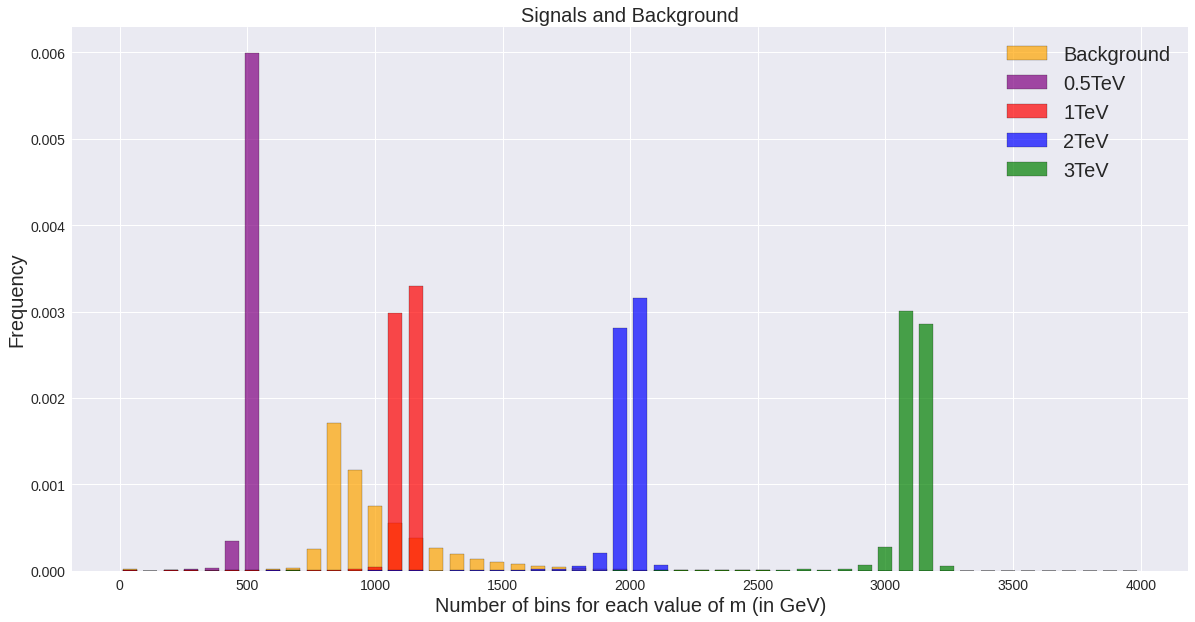

In [ ]:
plt.figure()

plt.bar(bg_df['mid'], bg_df['freq'], width = width, color='orange', ec = 'black', alpha = 0.7, label = 'Background')

plt.bar(signal_df_0_5['mid'], signal_df_0_5['freq'], width = width, color='purple', ec = 'black', alpha = 0.7, label = '0.5TeV')
# plt.bar(bg_df['mid'], bg_df['freq'], width = width, color='orange', ec = 'black', alpha = 0.7)

plt.bar(signal_df_1['mid'], signal_df_1['freq'], width = width, color='red', ec = 'black', alpha = 0.7, label = '1TeV')
# plt.bar(bg_df['mid'], bg_df['freq'], width = width, color='orange', ec = 'black', alpha = 0.7)

plt.bar(signal_df['mid'], signal_df['freq'], width = width, color='blue', ec = 'black', alpha = 0.7, label = '2TeV')

plt.bar(signal_df_3['mid'], signal_df_3['freq'], width = width, color='green', ec = 'black', alpha = 0.7, label = '3TeV')
# plt.bar(bg_df['mid'], bg_df['freq'], width = width, color='orange', ec = 'black', alpha = 0.7)



plt.xlabel("Number of bins for each value of m (in GeV)",fontsize = 20)
plt.ylabel("Frequency",fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('Signals and Background',fontsize=20)
plt.legend(fontsize = 20)

plt.savefig('Signals.png')
plt.show()

<BarContainer object of 50 artists>

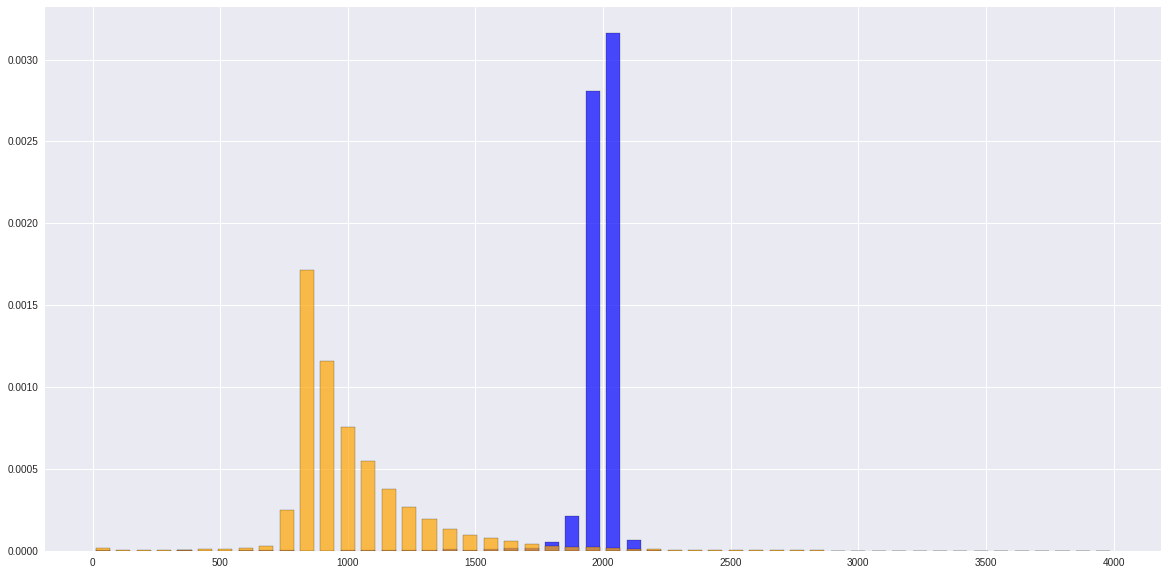

In [ ]:
plt.bar(signal_df['mid'], signal_df['freq'], width = width, color='blue', ec = 'black', alpha = 0.7)
plt.bar(bg_df['mid'], bg_df['freq'], width = width, color='orange', ec = 'black', alpha = 0.7)
plt.xlabel("Number of bins for each value of m (in GeV)",fontsize = 20)
plt.ylabel("Frequency",fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('Signal and Background',fontsize=20)
plt.legend(['Signal', 'Background'],fontsize = 20)
plt.savefig('2Tev.png')
plt.show()

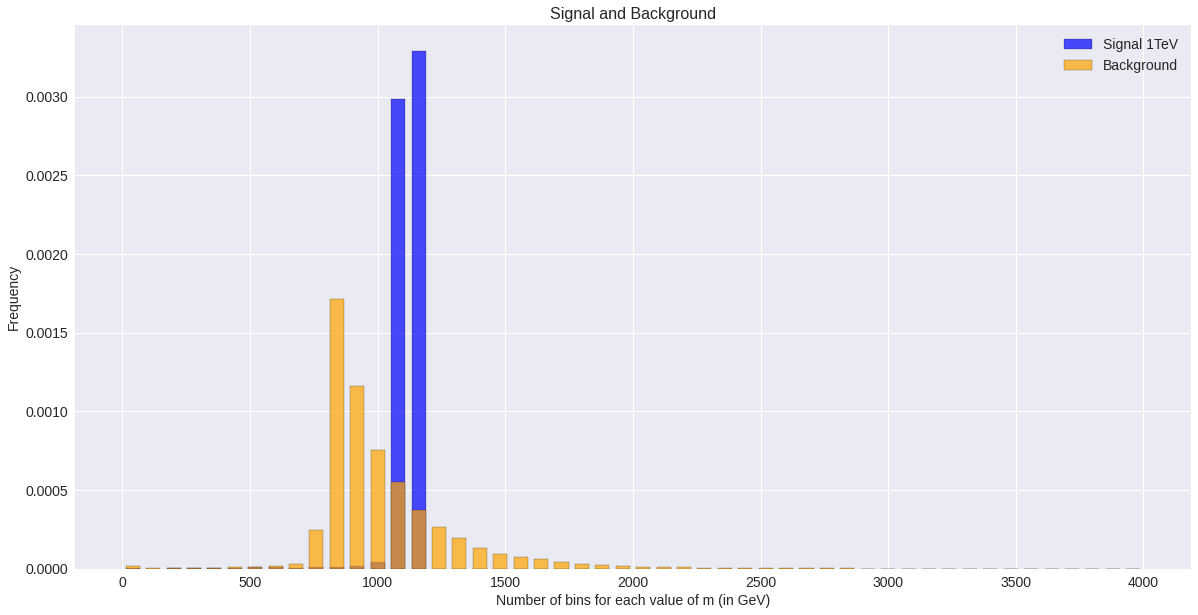

In [ ]:
plt.bar(signal_df_1['mid'], signal_df_1['freq'], width = width, color='blue', ec = 'black', alpha = 0.7)
plt.bar(bg_df['mid'], bg_df['freq'], width = width, color='orange', ec = 'black', alpha = 0.7)
plt.xlabel("Number of bins for each value of m (in GeV)",fontsize = 14)
plt.ylabel("Frequency",fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('Signal and Background',fontsize=16)
plt.legend(['Signal 1TeV', 'Background'],fontsize = 14)
plt.savefig('1Tev.png')
plt.show()

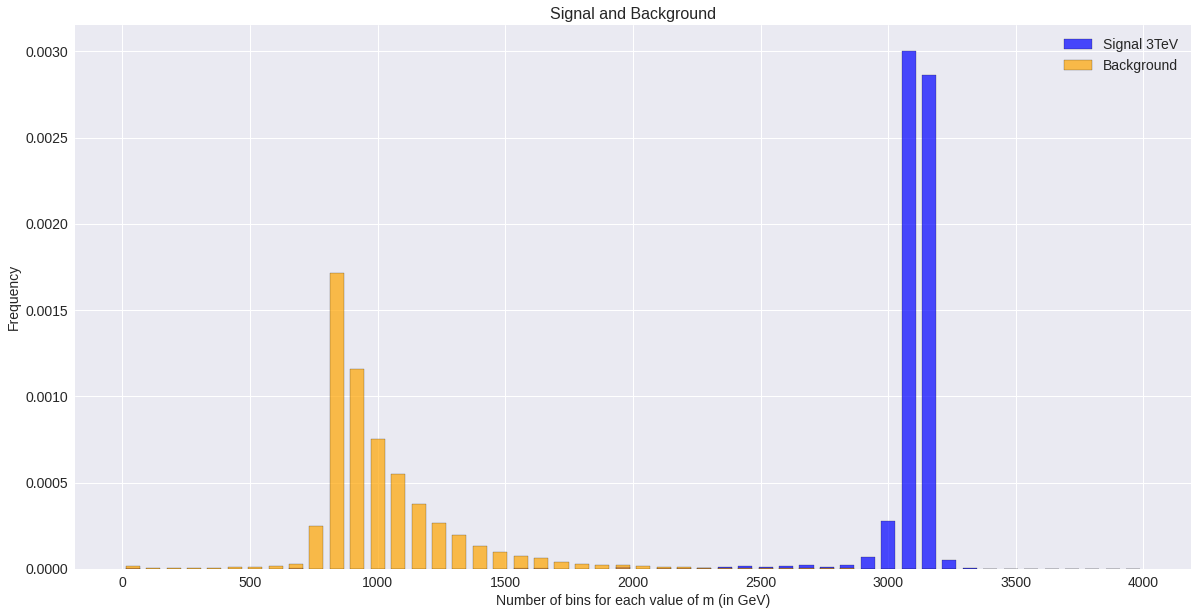

In [ ]:
plt.bar(signal_df_3['mid'], signal_df_3['freq'], width = width, color='blue', ec = 'black', alpha = 0.7)
plt.bar(bg_df['mid'], bg_df['freq'], width = width, color='orange', ec = 'black', alpha = 0.7)
plt.xlabel("Number of bins for each value of m (in GeV)",fontsize = 14)
plt.ylabel("Frequency",fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('Signal and Background',fontsize=16)
plt.legend(['Signal 3TeV', 'Background'],fontsize = 14)
plt.savefig('3Tev.png')
plt.show()

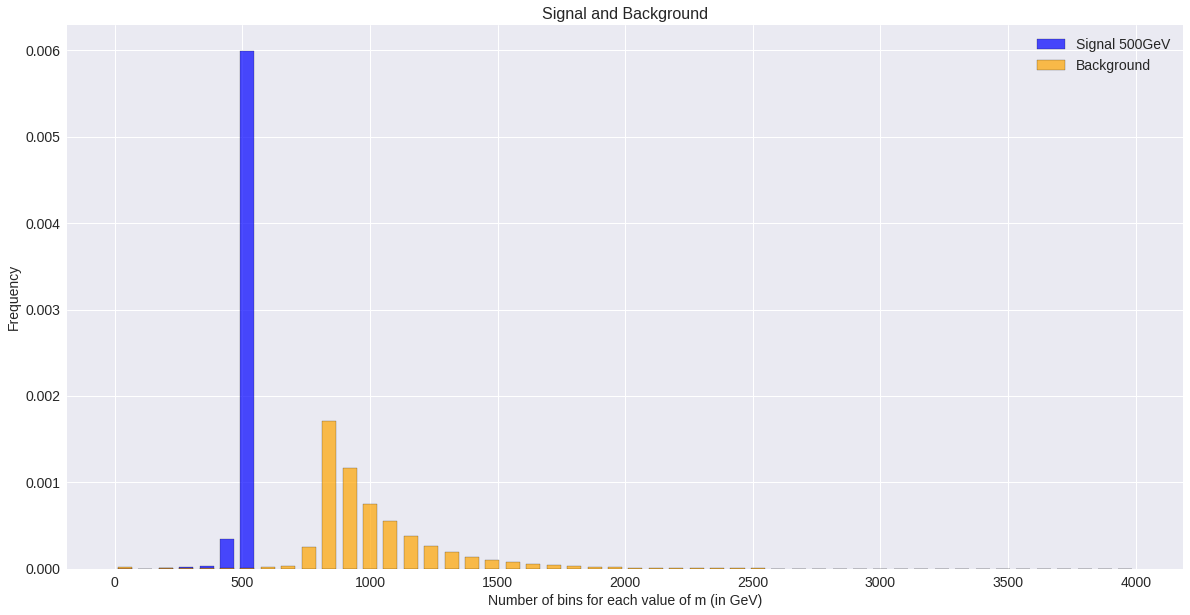

In [ ]:
plt.bar(signal_df_0_5['mid'], signal_df_0_5['freq'], width = width, color='blue', ec = 'black', alpha = 0.7)
plt.bar(bg_df['mid'], bg_df['freq'], width = width, color='orange', ec = 'black', alpha = 0.7)
plt.xlabel("Number of bins for each value of m (in GeV)",fontsize = 14)
plt.ylabel("Frequency",fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('Signal and Background',fontsize=16)
plt.legend(['Signal 500GeV', 'Background'],fontsize = 14)
plt.savefig('0.5Tev.png')
plt.show()

## **Preparing Data for Input to Model**

In [ ]:
x_test = pd.DataFrame({'signal_0_5': signal_df_0_5['freq'],
                       'signal_1': signal_df_1['freq'],
                       'signal': signal_df['freq'],
                       'signal_3': signal_df_3['freq'],
                      }).to_numpy()

x_test = x_test.T
x_test

array([[8.05388093e-06, 3.22155237e-06, 9.66465712e-06, 2.25508666e-05,
        3.22155237e-05, 3.46316880e-04, 5.99047664e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [7.27205716e-06, 1.45441143e-06, 4.36323429e-06, 4.36323429e-06,
        2.90882286e-06,

In [ ]:
x_train = bg_df[['freq']].to_numpy()
x_train = x_train.reshape(-1, 50)
x_train.shape

(1, 50)

In [ ]:
x_train

array([[1.51284169e-05, 3.43249796e-06, 3.81388662e-06, 5.33944127e-06,
        7.11925503e-06, 8.89906879e-06, 1.22044372e-05, 1.62725829e-05,
        2.88584088e-05, 2.49428185e-04, 1.71459630e-03, 1.16094709e-03,
        7.54895292e-04, 5.48436897e-04, 3.76557739e-04, 2.68116230e-04,
        1.96033772e-04, 1.33486032e-04, 9.64913316e-05, 7.65319916e-05,
        6.11493155e-05, 4.22070120e-05, 3.00025748e-05, 2.32647084e-05,
        2.02135991e-05, 1.42385101e-05, 1.00432348e-05, 8.64480968e-06,
        7.50064369e-06, 4.44953439e-06, 6.35647771e-06, 4.19527529e-06,
        3.30536841e-06, 2.28833197e-06, 2.28833197e-06, 2.16120242e-06,
        6.35647771e-07, 3.81388662e-07, 1.14416599e-06, 1.14416599e-06,
        3.81388662e-07, 1.27129554e-07, 1.27129554e-07, 5.08518217e-07,
        3.81388662e-07, 3.81388662e-07, 3.81388662e-07, 1.27129554e-07,
        0.00000000e+00, 3.81388662e-07]])

#### Generating new distributions with noise

In [ ]:
# Creating new backgrounds from original background

values = [1.05, 1, 0.95]

x_new = x_train*np.array(random.choices(values, k = 50)).reshape(1,-1)

for i in range(18):
  x = x_train*np.array(random.choices(values, k = 50)).reshape(1,-1)
  x_new = np.concatenate((x_new, x), axis = 0)

x_train2 = np.concatenate((x_train, x_new), axis = 0)
x_train2.shape

(20, 50)

In [ ]:
# Creating new signals from original background

values = [0.25, 0.5, 0.75, 1, 1.25, 1.50, 1.75, 2]

x_new = x_train*np.array(random.choices(values, k = 50)).reshape(1,-1)

for i in range(3):
  x = x_train*np.array(random.choices(values, k = 50)).reshape(1,-1)
  x_new = np.concatenate((x_new, x), axis = 0)

x_new.shape

(4, 50)

## **Model**

In [ ]:
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()

    self.encoder = Sequential([
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])

    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='relu')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train.shape[1])
# configurations of model

model.compile(loss='mse', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train2,
    x_train2,
    epochs=200,
)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 1.0567e-07 - mse: 1.0567e-07
Epoch 2/200
1/1 [==============================] - 0s 19ms/step - loss: 7.4083e-07 - mse: 7.4083e-07
Epoch 3/200
1/1 [==============================] - 0s 17ms/step - loss: 1.3890e-08 - mse: 1.3890e-08
Epoch 4/200
1/1 [==============================] - 0s 32ms/step - loss: 2.1563e-08 - mse: 2.1563e-08
Epoch 5/200
1/1 [==============================] - 0s 18ms/step - loss: 1.4257e-08 - mse: 1.4257e-08
Epoch 6/200
1/1 [==============================] - 0s 17ms/step - loss: 1.2608e-08 - mse: 1.2608e-08
Epoch 7/200
1/1 [==============================] - 0s 25ms/step - loss: 8.6370e-09 - mse: 8.6370e-09
Epoch 8/200
1/1 [==============================] - 0s 20ms/step - loss: 1.0606e-08 - mse: 1.0606e-08
Epoch 9/200
1/1 [==============================] - 0s 8ms/step - loss: 1.2899e-08 - mse: 1.2899e-08
Epoch 10/200
1/1 [==============================] - 0s 14ms/step - loss: 1.1797e-08 - mse: 1.1

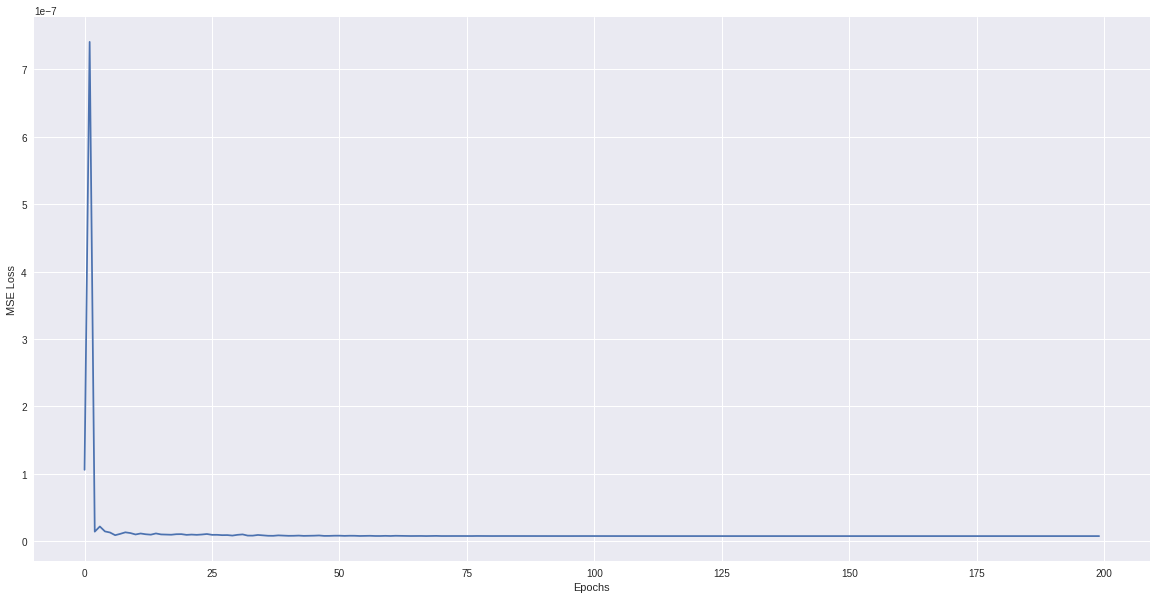

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
#plt.savefig('MSLE.png')
plt.show()

1/1 [==============================] - 0s 43ms/step


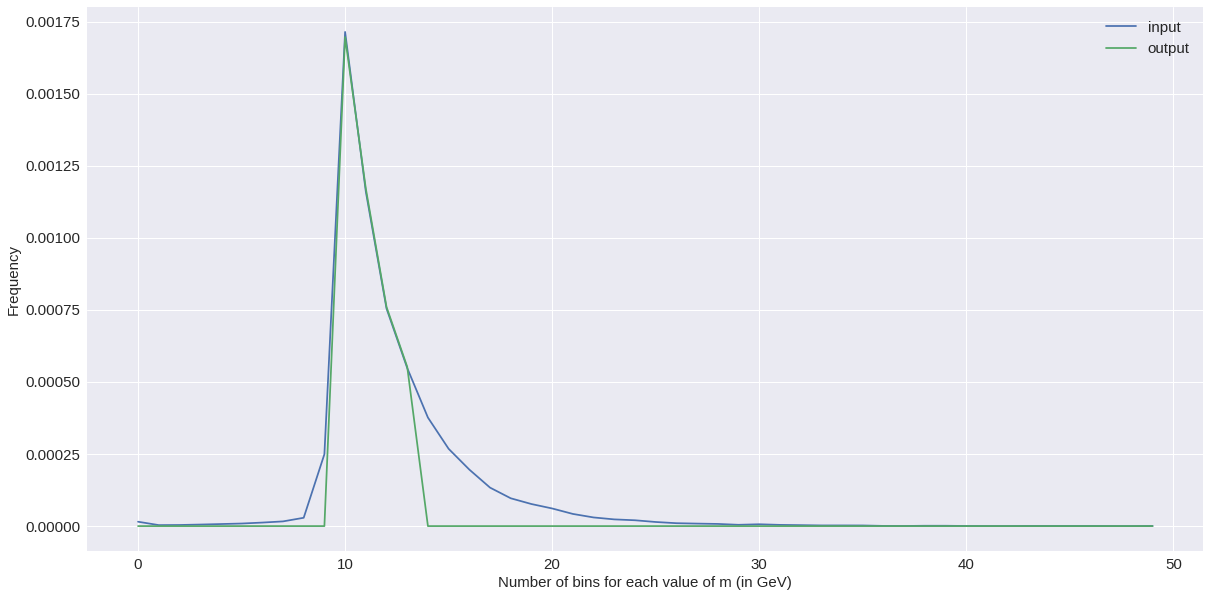

[7.13807408e-09]
Threshold: 7.138074077332806e-09


In [ ]:
def find_threshold(model, x_train):
  
  reconstructions = model.predict(x_train)

  plt.plot(x_train[0,:].reshape(50, -1), label = 'input')
  plt.plot(reconstructions[0,:].reshape(50, -1), label = 'output')
  plt.xlabel('Number of bins for each value of m (in GeV)',fontsize = 15)
  plt.ylabel('Frequency',fontsize = 15)
  plt.legend(fontsize = 15)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.show()

  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train)
  print(reconstruction_errors.numpy())

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())

  return threshold

threshold = find_threshold(model, x_train)
print(f"Threshold: {threshold}")

1/1 [==============================] - 0s 103ms/step


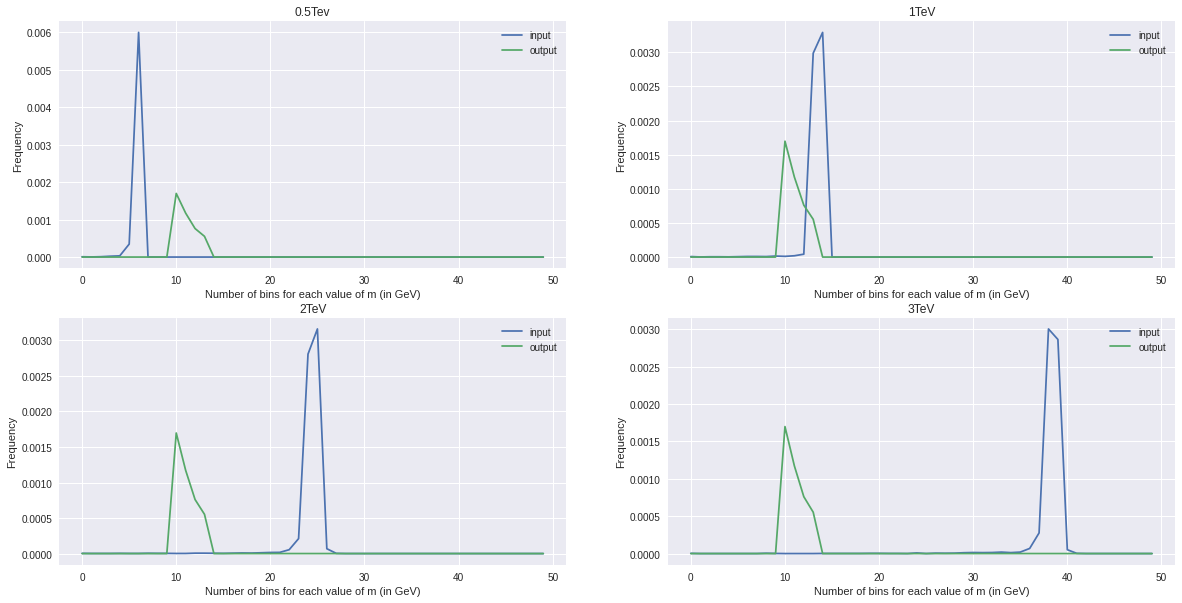

[8.18388433e-07 4.27394179e-07 4.59633184e-07 4.47203987e-07]
0    1.0
1    1.0
2    1.0
3    1.0
dtype: float64


In [ ]:
def get_predictions(model, x_test, threshold):
  predictions = model.predict(x_test)

  figure, axis = plt.subplots(2, 2)
    
  axis[0,0].plot(x_test[0,:].reshape(50, -1), label = 'input')
  axis[0,0].plot(predictions[0,:].reshape(50, -1), label = 'output')

  axis[0,1].plot(x_test[1,:].reshape(50, -1), label = 'input')
  axis[0,1].plot(predictions[1,:].reshape(50, -1), label = 'output')

  axis[1,0].plot(x_test[2,:].reshape(50, -1), label = 'input')
  axis[1,0].plot(predictions[2,:].reshape(50, -1), label = 'output')

  axis[1,1].plot(x_test[3,:].reshape(50, -1), label = 'input')
  axis[1,1].plot(predictions[3,:].reshape(50, -1), label = 'output')
  
  title_dict = {1: '0.5Tev', 2: '1TeV', 3: '2TeV', 4: '3TeV'}

  i = 1
  for ax in axis.flat:
    ax.set(xlabel='Number of bins for each value of m (in GeV)', ylabel='Frequency')
    ax.legend()
    ax.set_title(title_dict[i])
    i+=1

  plt.show()

  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test)
  print(errors.numpy())

  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
  print(preds)

  return preds

predictions = get_predictions(model, x_test, threshold)